In [ ]:
import os

with open('.env', 'r') as env:
    {line.split('=') env.read().split('\n')

In [2]:
import iexfinance
import os
import pandas as pd

# Setup cache for requests
import datetime
from iexfinance.stocks import Stock
import requests_cache


import numpy as np

def transform_index(prices: pd.DataFrame) -> pd.DataFrame:
    """
    transform index to datetime index
    """
    prices.index = prices.index.set_levels(pd.to_datetime(prices.index.levels[-1]), 1)
    return prices

def daily_returns(prices: pd.Series) -> pd.Series:
    return prices.pct_change(fill_value=0)

def cumulative_returns(retSeries: pd.Series) -> pd.Series:
    """
    return series of value from daily returns
    """
    return np.cumprod(1 + retSeries.astype('float').values)

def process_basket_data(prices: pd.DataFrame) -> pd.DataFrame:
    prices = transform_index(prices)
    prices['returns'] = daily_returns(prices.close)
    prices['cumulative_returns'] = cumulative_returns(prices.returns)
    return prices

def normalise_basket(prices, column='return'):
    df = pd.DataFrame()
    for ticker in list(prices.index.levels[0]):
        try:
            df[ticker] = prices.loc[ticker][column]
        except KeyError as ex:
            pass
    return df




expiry = datetime.timedelta(days=10)
session = requests_cache.CachedSession(cache_name='cache',
                                       backend='sqlite',
                                       expire_after=expiry)


vuke = Stock('VUKE-LN')

"""
purchased on 
Order summary
Estimated value more information £5,000.00 
Order number 5674775
Status updated
Date 03 March 2021
Time 10:16
Actual contract cost
Value £4,977.62
Settlement price £29.63
Contract total £4,977.62
"""

no_shares = 168.0000
buy_price = 29.63

price = vuke.get_price()
price = price['VUKE-LN'].values[0]

value = price * no_shares
returns = (price - buy_price)/price
print(f'value: {value}, return: {returns*100}%')

import json
import pandas as pd

# Static data
emea_cty_codes = ['AT','BE','BG','HR','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO','SK','SI','ES','SE','GB']

with open('./data/iex_exchanges.json', 'r') as fil:
    df = pd.read_json(fil)
iex_exchanges = df

from iexfinance.refdata import get_region_symbols

def download_symbol_static():
    df = pd.DataFrame()
    for cty_code in emea_cty_codes:
        if cty_code in iex_exchanges.region.values:
            symbols = get_region_symbols(cty_code)
            if len(symbols) == 0:
                print(f'cty_code={cty_code} not found')
                continue
            df = df.append(symbols)
        else:
            print(f'cty_code={cty_code} is not supported by iex')
    all_emea_symbols = df
    all_emea_symbols.to_csv('data/all_emea_symbols.csv')
    return all_emea_symbols

# EMEA Universe
all_emea_symbols = pd.read_csv('./data/all_emea_symbols.csv')

# FTSE 100 data
ftse_companies = pd.read_csv('./data/ftse100.csv')
ftse_tickers = list(map(lambda tick: f'{tick}-LN', ftse_companies.Code))

# data on vanguard etfs
vg_etfs = pd.read_csv('/home/rory/dev/investment-analysis/data/vanguard_fund_summaries.csv')
vanguard_funds = all_emea_symbols[all_emea_symbols.name.str.contains('Vanguard')]
vanguard_funds.name

# Vanguard etf tickers
tickers=list(map(lambda it: it.replace(' ', '-'), list(vg_etfs.Bloomberg)))




value: 5020.68, return: 0.8532708716747618%


In [48]:
################
# Model Features
################
# VG ETF prices
vg_etf_basket = Stock(tickers, session=session)
vg_etf_prices = vg_etf_basket.get_historical_prices(range='5y')
vg_etf_prices = process_basket_data(vg_etf_prices)

# VG Momentum funds
momentum_etfs = Stock(list(vanguard_funds[vanguard_funds.symbol.str.contains('VMOM')].symbol.values), session=session)
momentum_prices = momentum_etfs.get_historical_prices(range='5y')
momentum_prices = process_basket_data(momentum_prices)

# FTSE 100 names
ftse_basket = Stock(list(ftse_tickers[0:100]), session=session)
ftse_basket_prices = ftse_basket.get_historical_prices(range='5y')
ftse_basket_prices = process_basket_data(ftse_basket_prices)

# Filter out columns with too few observations
mask = [tick for tick in filter(lambda ticker: ftse_basket_prices.loc[ticker].close.size >=1200, ftse_basket_prices.index.levels[0])]
ftse_basket_prices = ftse_basket_prices.loc[mask]


####################
# Prediction Targets
####################
# FTSE100 INDEX
ftse100 = Stock('VUKE-LN', session=session)
ftse100_prices = ftse100.get_historical_prices(range='5y')
ftse100_prices.index = pd.to_datetime(ftse100_prices.index)

ftse250 = Stock('VMID-LN', session=session)
ftse250_prices = ftse250.get_historical_prices(range='5y')
ftse250_prices.index = pd.to_datetime(ftse250_prices.index)
ftse250_prices


ftse_basket_prices.index.levels[0]

ftse_prediction = normalise_basket(ftse_basket_prices, 'returns').dropna()
ftse_prediction['index'] = daily_returns(ftse100_prices.close.astype('float'))
ftse_prediction['target'] = ftse_prediction['index'].astype('float').apply(lambda ret: 1 if ret > 0 else 0)

ftse_prediction = ftse_prediction.dropna()[1:]

## apply lag to X
period_lag = 5

ftse_prediction['target'] = ftse_prediction.target.shift(period_lag)

#ftse_prediction

ftse_prediction = ftse_prediction[period_lag:]


#################
# Features Subset
#################
test_cols = list(filter(lambda it: it not in [ 'index', 'target'], ftse_prediction.columns))


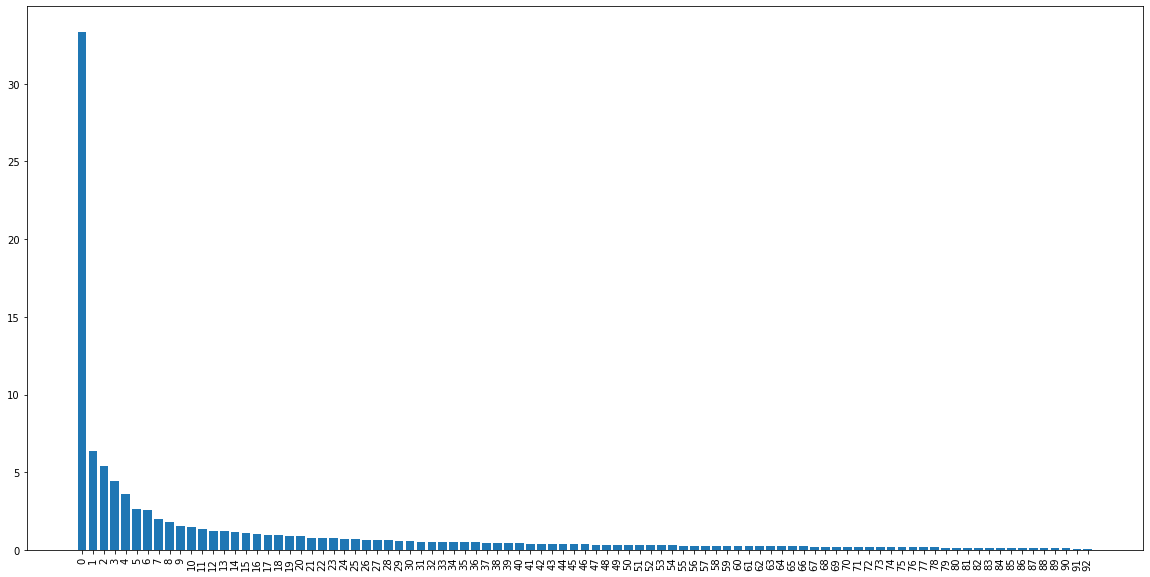

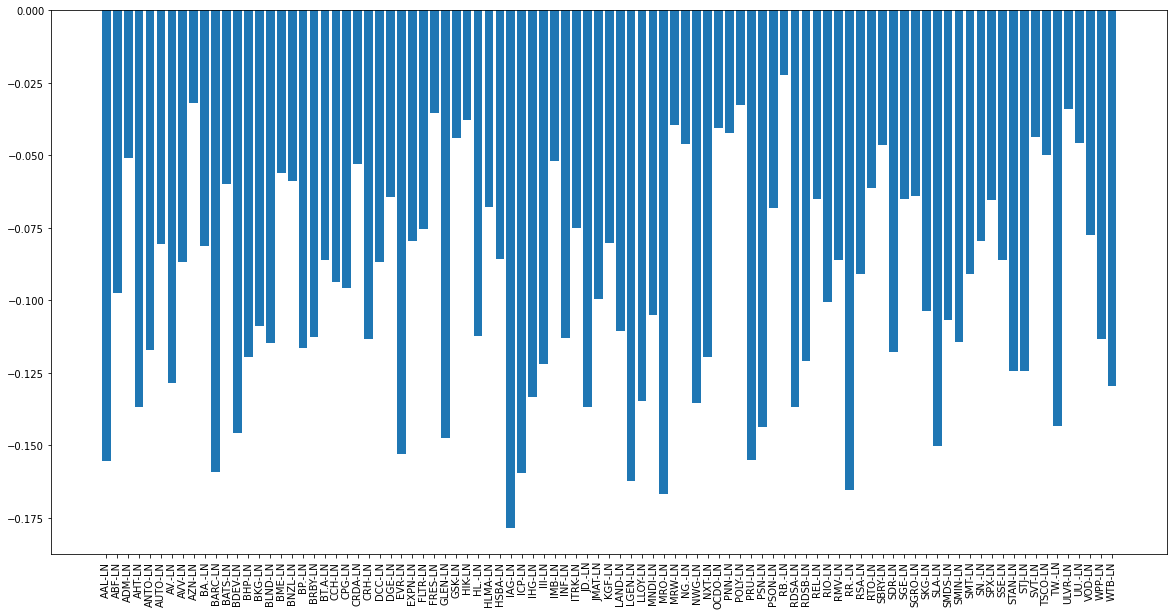

In [34]:
# Principal Component Analysis

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

df = ftse_prediction[list(filter(lambda ticker: ticker not in  ['index', 'target'], ftse_prediction.columns))]

#basket_returns = ftse_prediction#normalise_basket(df, 'returns')
pca = PCA()
pca.fit(df)

plt.figure(figsize=(20,10))
y = np.round(pca.explained_variance_ratio_* 100, decimals =2)
plt.bar(x=range(0, pca.components_[0].size), height=y)
plt.xticks(range(0, pca.components_[0].size), rotation=90)
plt.show()

# Visualise first component
plt.figure(figsize=(20,10))
plt.bar(x=range(0, pca.components_[0].size), height=pca.components_[0])
plt.xticks(range(0, pca.components_[0].size), df.columns, rotation=90)
plt.show()

ftse_pca_score = pca.transform(df)

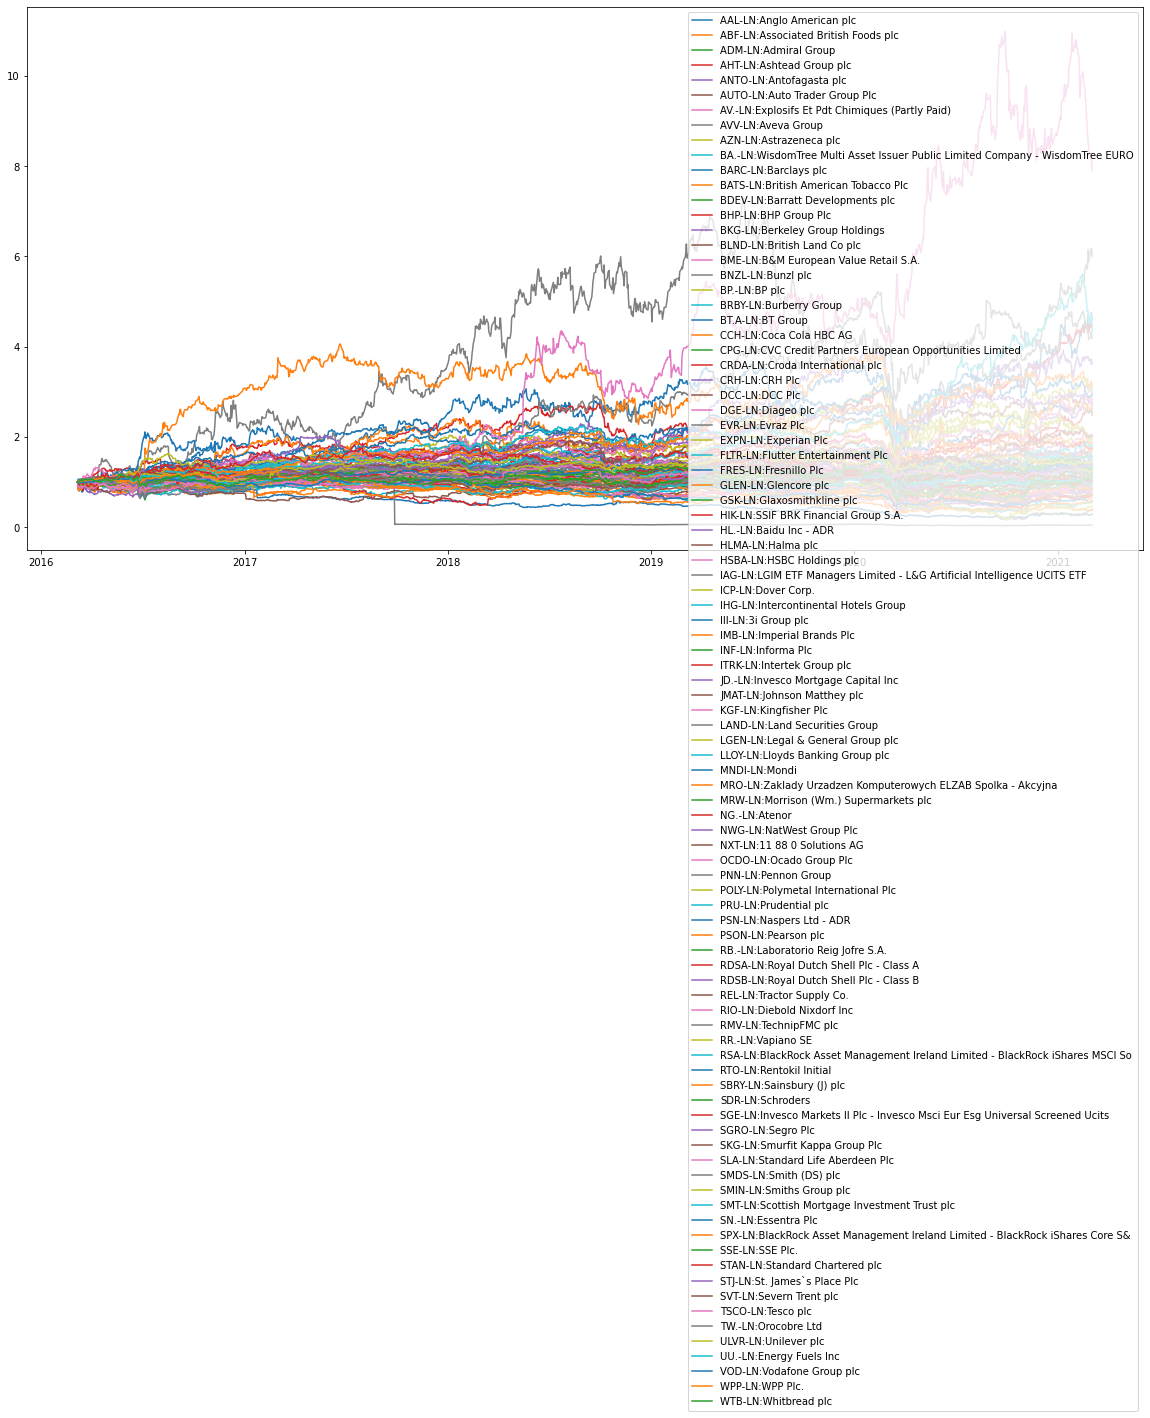

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

start_date = pd.to_datetime('25/07/2016')
end_date = pd.to_datetime('26/02/2021')
mask = lambda s: (s.index > start_date) & (s.index <= end_date)

def basket_cumulative_return(prices, name=None):
    plt.figure(figsize=(20,10))
    if not isinstance(prices.index, pd.MultiIndex):
        verg = prices.loc[ticker]
        subset = verg#.loc[mask(verg)]
        cumReturns = cumulative_returns(subset.changePercent)
        plt.plot(subset.index, cumReturns, label=name)
    else:
        for ticker in prices.index.levels[0]:
            all_emea_symbols[all_emea_symbols.symbol == name]
            try:
                verg = prices.loc[ticker]
                subset = verg#.loc[mask(verg)]
                cumReturns = cumulative_returns(subset.changePercent)
                shortname = all_emea_symbols[all_emea_symbols.symbol.str.contains(ticker)].name.values[0]
                plt.plot(subset.index, cumReturns, label=f'{ticker}:{shortname}')
            except KeyError as ex:
                pass
    plt.legend()


#basket_cumulative_return(vg_etf_prices)
basket_cumulative_return(ftse_basket_prices)

            
plt.show()
#prices.loc[mask]

In [38]:
#######################
# Train/Test subsetting
#######################
from datetime import datetime

train_start = pd.to_datetime('16/05/2019')
train_end = pd.to_datetime('31/01/2021')

train_mask = lambda s: (s.index > train_start) & (s.index <= train_end)
test_mask = lambda s: (s.index > train_end) & (s.index <= datetime.now())


In [42]:
######################
# Lasso regression
#  y: ftse price 
#  X: basket of stocks
######################
from sklearn.linear_model import Lasso

X_train=ftse_prediction[train_mask(ftse_prediction)][list(filter(lambda it: it != 'index', ftse_prediction.columns))]
y_train=ftse_prediction[train_mask(ftse_prediction)]['index']

X_test = ftse_prediction[test_mask(ftse_prediction)][list(filter(lambda it: it != 'index', ftse_prediction.columns))]
y_test = ftse_prediction[test_mask(ftse_prediction)]['index']
clf = Lasso(alpha=0.1)
clf.fit(X=X_train, y=y_train)
print(f'Train Score: {clf.score(X=X_train, y=y_train)}')
print(f'Model score: {clf.score(X=X_test, y=y_test)}')
clf.get_params()


Train Score: 0.0
Model score: -0.06562209311012479


{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

/home/rory/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rory/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rory/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  index   No. Observations:                 1253
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3786.532
Date:                Tue, 09 Mar 2021   AIC                          -7561.064
Time:                        22:39:12   BIC                          -7530.269
Sample:                             0   HQIC                         -7549.488
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8222      0.017    -48.846      0.000      -0.855      -0.789
ar.L2         -0.6480      0.024    -27.107      0.000      -0.695      -0.601
ar.L3         -0.4988      0.023    -21.279      0.0

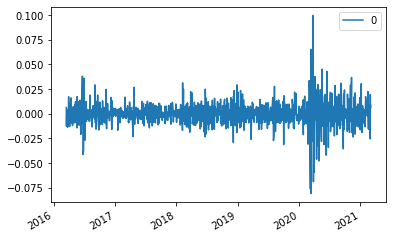

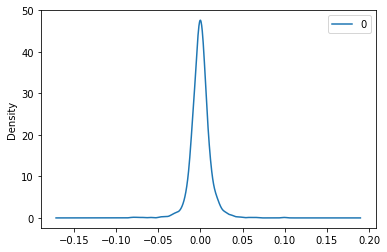

                 0
count  1253.000000
mean      0.000005
std       0.011756
min      -0.080896
25%      -0.005582
50%      -0.000176
75%       0.005113
max       0.099487


In [46]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset

series = ftse_prediction['index'].astype('float')

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [80]:
###########################################
# Lasso regression on classification target
# of increase or decrease daily returns
###########################################

X_train=ftse_prediction[train_mask(ftse_prediction)][list(filter(lambda it: it not in ['index','target'], ftse_prediction.columns))]
y_train=ftse_prediction[train_mask(ftse_prediction)]['target'].astype('int')

X_test = ftse_prediction[test_mask(ftse_prediction)][list(filter(lambda it: it not in ['index','target'], ftse_prediction.columns))]
y_test = ftse_prediction[test_mask(ftse_prediction)]['target'].astype('int')
clf = Lasso(alpha=0.001)
clf.fit(X=X_train, y=y_train)
clf.score(X=X_test, y=y_test)


0.011931426137551937

In [49]:
clf.predict(X=X_test)

array([0.53126946, 0.54192971, 0.50519048, 0.53571891, 0.54370029,
       0.54079483, 0.52816402, 0.52109319, 0.49999902, 0.51133859,
       0.57144328, 0.50276431, 0.49557139, 0.520258  , 0.54162393,
       0.57036376, 0.53461975, 0.55267425, 0.521907  , 0.48670757,
       0.58854384, 0.50969445, 0.58684643])

In [77]:
from sklearn.neighbors import  NearestCentroid
train_mask(ftse_prediction)

features_train = ftse_prediction[train_mask(ftse_prediction)][test_cols]
features_test = ftse_prediction[test_mask(ftse_prediction)][test_cols]
target_train = ftse_prediction[train_mask(ftse_prediction)][['target']].astype('int')
target_test = ftse_prediction[test_mask(ftse_prediction)]['target'].astype('int')

pca = PCA()
target = ftse_prediction['target']

clf = NearestCentroid()

#pca.fit(features_train)
#features_train = pca.transform(features_train)
#features_test = pca.transform(features_test)
clf.fit(X=features_train, y=target_train)

clf.score(y=target_test, X=features_test)

/home/rory/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.48148148148148145

In [81]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

lr_list = [0.75, 1, 1.1, 1.2, 1.3, 1.4]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=30, max_depth=10, random_state=0)
    gb_clf.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))
    
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.75, max_features=30, max_depth=10, random_state=0)
gb_clf.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))


Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.630
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.556
Learning rate:  1.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.519
Learning rate:  1.2
Accuracy score (training): 1.000
Accuracy score (validation): 0.593
Learning rate:  1.3
Accuracy score (training): 1.000
Accuracy score (validation): 0.481
Learning rate:  1.4
Accuracy score (training): 1.000
Accuracy score (validation): 0.444
Accuracy score (training): 1.000
Accuracy score (validation): 0.630


In [91]:
from sklearn.ensemble import GradientBoostingRegressor

X_train=ftse_prediction[train_mask(ftse_prediction)][test_cols]
y_train=ftse_prediction[train_mask(ftse_prediction)]['index']
X_test = ftse_prediction[test_mask(ftse_prediction)][test_cols]
y_test = ftse_prediction[test_mask(ftse_prediction)]['index']

gb_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate=learning_rate, max_features=90, max_depth=50, random_state=3)
gb_reg.fit(X_train, y_train)
gb_reg.score(X_test, y_test)

GradientBoostingRegressor(learning_rate=1.4, max_depth=50, max_features=90,
                          n_estimators=1000, random_state=3)

In [ ]:
clf.

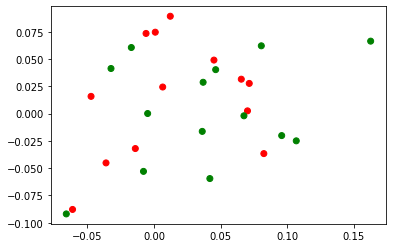

In [103]:
clf = gb_clf

clf.predict(features_test)
pca.fit(features_train)
feat_test_df = pd.DataFrame(pca.transform(features_test))
prediction = clf.predict(features_test)


def printtable():
    print(f'|Actual| Pred| PC1| PC2')
    print(f'--------------')

    for pred, act, pc1, pc2, targ in zip(clf.predict(features_test), 
                                         target_test, 
                                         feat_test_df[0], 
                                         feat_test_df[1], 
                                         ftse_prediction['index']):
        print('     {}|    {}|   {:0.2f}|   {:0.2f}|  {:0.2f}'.format(act, pred, pc1, pc2, targ))
        print('--------------')


cols = ['Actual', 'Predicted', 'PC1', 'PC2']
vals = [target_test, clf.predict(features_test)]

to_plot = pd.DataFrame()

to_plot['PC1'] = feat_test_df[0]
to_plot['PC2'] = feat_test_df[1]
to_plot['PC3'] = feat_test_df[2]
to_plot['PC4'] = feat_test_df[3]
to_plot['Actual'] = target_test.values
to_plot['Predicted'] = clf.predict(features_test)
fig, ax = plt.subplots()
colors = {0: 'red', 1: 'green'}
ax.scatter(to_plot['PC2'], to_plot['PC3'], c=to_plot['Actual'].map(colors))
plt.show()


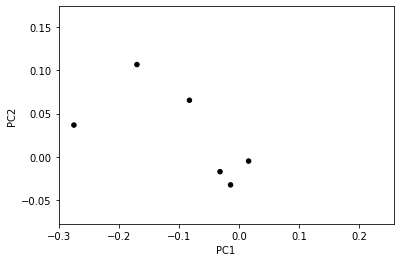

In [104]:
ax1 = to_plot.plot.scatter(x='PC1', y='PC2', color=to_plot['Predicted'])



In [107]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train=ftse_prediction[train_mask(ftse_prediction)][test_cols]
y_train=ftse_prediction[train_mask(ftse_prediction)]['target'].astype('int')
X_test = ftse_prediction[test_mask(ftse_prediction)][test_cols]
y_test = ftse_prediction[test_mask(ftse_prediction)]['target'].astype('int')

clf = SVC(kernel='sigmoid')
clf.fit(X=features_train,y=target_train)
y_pred = clf.predict(features_test)
print(accuracy_score(y_test,y_pred))

0.48148148148148145


/home/rory/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [109]:
last_week = ftse_basket.get_historical_prices(range='1w')

last_week = process_basket_data(last_week)
last_week_data = normalise_basket(last_week, 'returns')
last_week_data

features = last_week_data[list(filter(lambda col: col not in ['filter', 'target'], last_week_data.columns))]

features = features[features.replace([np.inf, -np.inf], np.nan).notnull()]
features = features[filter(lambda item: item not in ['target', 'index'] ,ftse_prediction.columns)]

last_week_target = ftse100.get_historical_prices(range='1w').close.astype('float').pct_change()
features['target'] = last_week_target

features

,AAL-LN,ABF-LN,ADM-LN,AHT-LN,ANTO-LN,AUTO-LN,AV.-LN,AVV-LN,AZN-LN,BA.-LN,...,STJ-LN,SVT-LN,TSCO-LN,TW.-LN,ULVR-LN,UU.-LN,VOD-LN,WPP-LN,WTB-LN,target
2021-03-02,-0.143746,-0.684988,2.359227,1.663758,-0.763949,-0.891150,2.276241,2.914591,6.692308,-0.749494,...,0.525676,0.990152,-0.902840,-0.945784,1.464124,0.521724,-0.958054,0.068882,15.250000,NaN
2021-03-03,0.009298,0.006760,-0.016563,0.028975,-0.005666,0.011311,0.027346,-0.014773,-0.012500,0.007265,...,0.030894,-0.024741,-0.002698,0.059976,0.000000,-0.020394,0.008698,0.031087,0.055490,0.009392
2021-03-04,-0.032831,-0.000420,-0.026692,-0.022037,-0.062958,-0.012583,0.012265,-0.014418,0.009273,-0.003406,...,-0.042192,0.018911,-0.011271,-0.019050,0.011018,0.019894,0.003833,-0.020687,-0.016134,-0.000338
2021-03-05,0.009179,-0.010915,-0.033954,-0.027541,-0.000290,-0.020885,0.006445,-0.022528,0.000146,-0.027945,...,-0.003294,0.012675,0.021432,-0.009275,0.009600,0.020186,-0.009227,-0.002022,-0.035058,-0.004654
2021-03-08,0.036039,0.002547,-0.009125,0.039135,0.021437,0.002531,0.016137,0.016761,0.021435,0.026680,...,0.028501,-0.014752,-0.018750,0.045348,-0.000257,-0.021120,0.012042,0.038280,0.042778,0.013347
2021-03-09,-0.044062,0.021169,0.005457,0.037661,-0.012479,0.028850,-0.002017,0.016780,0.017987,0.005036,...,-0.004418,0.013158,0.006369,0.002239,0.006941,0.015671,0.012851,-0.013012,-0.017421,0.002852


In [111]:
print(gb_clf.predict(features[test_cols].dropna()))

[1 0 0 0 0]


In [112]:
last_week_target

2021-03-02         NaN
2021-03-03    0.009392
2021-03-04   -0.000338
2021-03-05   -0.004654
2021-03-08    0.013347
2021-03-09    0.002852
Name: close, dtype: float64